In [7]:
!py -m pip uninstall -y imbalanced-learn
!py -m pip uninstall -y scikit-learn
! py -mpip install scikit-learn==1.3.2 imbalanced-learn==0.11.0



# !py -m pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-openai langchain-chroma bs4

Found existing installation: imbalanced-learn 0.11.0
Uninstalling imbalanced-learn-0.11.0:
  Successfully uninstalled imbalanced-learn-0.11.0
Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2


You can safely remove it manually.


  Using cached scikit_learn-1.3.2-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl.metadata (8.3 kB)
Using cached scikit_learn-1.3.2-cp310-cp310-win_amd64.whl (9.3 MB)
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.4.1 requires packaging<22.0,>=0.21, but you have packaging 23.2 which is incompatible.


In [ ]:
# Delete cached .pyc files and __pycache__ folders
# import os
# import shutil

# for root, dirs, files in os.walk("c:/Users/SujaySunilNagvekar/AppData/Local/Programs/Python/Python310/lib/site-packages/imblearn"):
#     for d in dirs:
#         if d == "__pycache__":
#             shutil.rmtree(os.path.join(root, d))


In [6]:
!py -m pip list

Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.0.0
aiohttp                                  3.9.5
aiosignal                                1.3.1
aiosqlite                                0.21.0
altair                                   5.3.0
annotated-types                          0.6.0
anyio                                    3.5.0
argon2-cffi                              21.3.0
argon2-cffi-bindings                     21.2.0
asgiref                                  3.8.1
asttokens                                2.0.5
astunparse                               1.6.3
async-timeout                            4.0.3
asyncio                                  3.4.3
attrs                                    21.4.0
Babel                                    2.9.1
backcall                                 0.2.0
backoff                                  2.2.1
bcrypt                                  

typing-inspect                           0.9.0
tzdata                                   2024.1
ujson                                    5.10.0
unstructured                             0.15.13
unstructured-client                      0.22.0
urllib3                                  2.2.1
utils                                    1.0.2
uvicorn                                  0.29.0
wasabi                                   1.1.3
watchdog                                 4.0.0
watchfiles                               0.21.0
wcwidth                                  0.2.5
weasel                                   0.4.1
webencodings                             0.5.1
websocket-client                         1.2.3
websockets                               12.0
Werkzeug                                 2.0.2
wheel                                    0.45.1
widgetsnbextension                       4.0.11
wordcloud                                1.9.3
wrapt                                    1.13.3
xgbo

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import joblib
import random
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier


In [25]:
# === Step 1: Load your full dataset ===
df = pd.read_csv("claims_with_notes.csv")  # Replace with your real filename
df = df.rename(columns={"Litigation ": "Litigation"})
df["Litigation"] = df["Litigation"].map({"Yes": 1, "No": 0})
df = df.dropna(subset=["Litigation"])

# === Feature columns ===
text_cols = [
    'Loss cause', 'Loss Location State', 'Vehicle Make', 'Vehicle Model',
    'Damage Description', 'Claim Status', 'Medical & Injury Documentation',
    'Medical Reports', 'Hospital Records', 'Third-Party Information',
    'Subro Opportunity', 'Third-Party Insurance', 'Third-Party Claim Form'
]
num_cols = ['Vehicle Year', 'Repair Estimate', 'Repair Bill', 'Medical bill', 'Total Claim Bill']
feature_cols = text_cols + num_cols

# === Fill NA values ===
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in text_cols:
    valid_choices = df[col].dropna().unique()
    df[col] = df[col].apply(lambda x: random.choice(valid_choices) if pd.isna(x) else x)

# === Split into train/test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Litigation"], random_state=42)
X_train_raw = train_df[feature_cols].copy()
y_train = train_df["Litigation"].astype(int)
X_test_raw = test_df[feature_cols].copy()
y_test = test_df["Litigation"].astype(int)

# === OneHot for SMOTE (use get_dummies first)
X_train_encoded = pd.get_dummies(X_train_raw, columns=text_cols)
X_test_encoded = pd.get_dummies(X_test_raw, columns=text_cols)

# Align train and test columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# === Apply SMOTE before model training
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_encoded, y_train)

# === Train Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_res, y_train_res)

# === Save model and encoder columns
joblib.dump(clf, "logreg_litigation_model.pkl")
joblib.dump(X_train_encoded.columns.tolist(), "logreg_columns.pkl")
print("✅ Logistic Regression model trained with SMOTE.")

✅ Logistic Regression model trained with SMOTE.



🔍 Threshold: 0.5
              precision    recall  f1-score   support

           0      0.960     0.966     0.963       149
           1      0.000     0.000     0.000         6

    accuracy                          0.929       155
   macro avg      0.480     0.483     0.482       155
weighted avg      0.923     0.929     0.926       155


🔍 Threshold: 0.4
              precision    recall  f1-score   support

           0      0.959     0.946     0.953       149
           1      0.000     0.000     0.000         6

    accuracy                          0.910       155
   macro avg      0.480     0.473     0.476       155
weighted avg      0.922     0.910     0.916       155


🔍 Threshold: 0.3
              precision    recall  f1-score   support

           0      0.959     0.933     0.946       149
           1      0.000     0.000     0.000         6

    accuracy                          0.897       155
   macro avg      0.479     0.466     0.473       155
weighted avg      0.

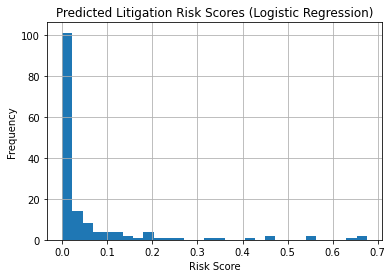

🔁 ROC AUC Score: 0.786


In [28]:
import pandas as pd
import joblib
import random
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
# === Load model and feature list ===
model = joblib.load("logreg_litigation_model.pkl")
feature_columns = joblib.load("logreg_columns.pkl")


# === Load dataset and test claim IDs ===
df = pd.read_csv("claims_with_notes.csv")
df = df.rename(columns={"Litigation ": "Litigation"})
df["Litigation"] = df["Litigation"].map({"Yes": 1, "No": 0})
test_ids = pd.read_csv("test_claim_ids.csv")["Claim Number"].tolist()

# Define feature columns
text_cols = [
    'Loss cause', 'Loss Location State', 'Vehicle Make', 'Vehicle Model',
    'Damage Description', 'Claim Status', 'Medical & Injury Documentation',
    'Medical Reports', 'Hospital Records', 'Third-Party Information',
    'Subro Opportunity', 'Third-Party Insurance', 'Third-Party Claim Form'
]
num_cols = ['Vehicle Year', 'Repair Estimate', 'Repair Bill', 'Medical bill', 'Total Claim Bill']
feature_cols = text_cols + num_cols

# === Filter + fill test data ===
df_test = df[df["Claim Number"].isin(test_ids)].copy()
df_test = df_test.dropna(subset=["Litigation"])
for col in num_cols:
    df_test[col] = df_test[col].fillna(df[col].median())
for col in text_cols:
    valid_choices = df[col].dropna().unique()
    df_test[col] = df_test[col].apply(lambda x: random.choice(valid_choices) if pd.isna(x) else x)

# === One-hot encode test data ===
X_test_encoded = pd.get_dummies(df_test[feature_cols], columns=text_cols)
X_test_encoded = X_test_encoded.reindex(columns=feature_columns, fill_value=0)
y_test = df_test["Litigation"].astype(int)

# === Predict probabilities and evaluate ===
y_probs = model.predict_proba(X_test_encoded)[:, 1]

# === Threshold tuning
for t in [0.5, 0.4, 0.3, 0.2]:
    print(f"\n🔍 Threshold: {t}")
    y_pred = (y_probs >= t).astype(int)
    print(classification_report(y_test, y_pred, digits=3))

# === Visualize risk score distribution
plt.hist(y_probs, bins=30)
plt.title("Predicted Litigation Risk Scores (Logistic Regression)")
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# === AUC Score
print("🔁 ROC AUC Score:", round(roc_auc_score(y_test, y_probs), 3))


In [29]:


# Show claims where Litigation = 1
litigation_cases = df_test[df_test["Litigation"] == 1][["Claim Number", "Litigation"]]

print("🧾 Claims with actual Litigation = 1 in test set:")
print(litigation_cases.to_string(index=False))


🧾 Claims with actual Litigation = 1 in test set:
Claim Number  Litigation
    C9CB6205         1.0
    46AD8194         1.0
    180FE664         1.0
    17236384         1.0
    E599CE2B         1.0
    B9FAA504         1.0
